# Sustainability project - data analysis

Notebook for data visualization and analysis

In [1]:
import sys
sys.path.append('/Users/fabiomenegazzo/Documents/Università/codes')
import os
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['pcolor.shading'] = 'auto'
from helpers import *
from Gillespie import *
from CPRsust_rates import *
from extinctionTimes import *
from CPRSust_detEqs import *

tolerance = 1e-3
cutFrac = 0.8

nodeStates = [0,1,2,3]

inputCommonDir = 'output' 
if not os.path.isdir(inputCommonDir):
    raise FileNotFoundError(f'Folder for the inputs not found at relative path: {inputCommonDir}. Perform the data prduction first.')
methodsStrVec = ['MF','detRes','stocRes']
intputDirsVec = [inputCommonDir+'/'+s for s in methodsStrVec]

paramsLabel = 'parameters'
seriesLabel = 'series'

## Mean field

Import data.

In [2]:
fileList_MF = [f for f in os.listdir(intputDirsVec[0]) if f.endswith('.json')]
if not fileList_MF:
    print('No data found.')
    runMF = False
else:
    print(f'{len(fileList_MF)} files found:')
    print(json.dumps(fileList_MF, indent=4))
    runMF = True

    print('Importing.')
    dataObj_MF = []
    for fName in fileList_MF:
        with open(os.path.join(intputDirsVec[0], fName), 'r') as f:
            data = json.load(f)
            dataObj_MF.append(data)
    print('Done.')

66 files found:
[
    "outMF_N200.00_K1000.00_b1.10_ehatC0.70_ehatD1.40_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.00_ehatC0.70_ehatD1.70_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.20_ehatC0.70_ehatD1.10_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.50_ehatC0.70_ehatD1.90_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.30_ehatC0.70_ehatD1.20_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.00_ehatC0.70_ehatD1.60_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.10_ehatC0.70_ehatD1.50_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.50_ehatC0.70_ehatD1.80_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.30_ehatC0.70_ehatD1.30_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.20_ehatC0.70_ehatD1.30_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.40_ehatC0.70_ehatD1.80_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.00_ehatC0.70_ehatD1.50_xi0.50_Ri0.50.json",
    "outMF_N200.00_K1000.00_b1.10_ehatC0.70_ehatD1.60_xi0.50_Ri0.50.json",
    "ou

### Visualize a single time series

Paremeter set
{
    "N": 200,
    "K": 1000,
    "b": 1.5000000000000004,
    "ehatC": 0.7,
    "ehatD": 1.9000000000000008,
    "xi": 0.5,
    "Ri": 0.5
}

Evaluating the time to extinction
	Done.


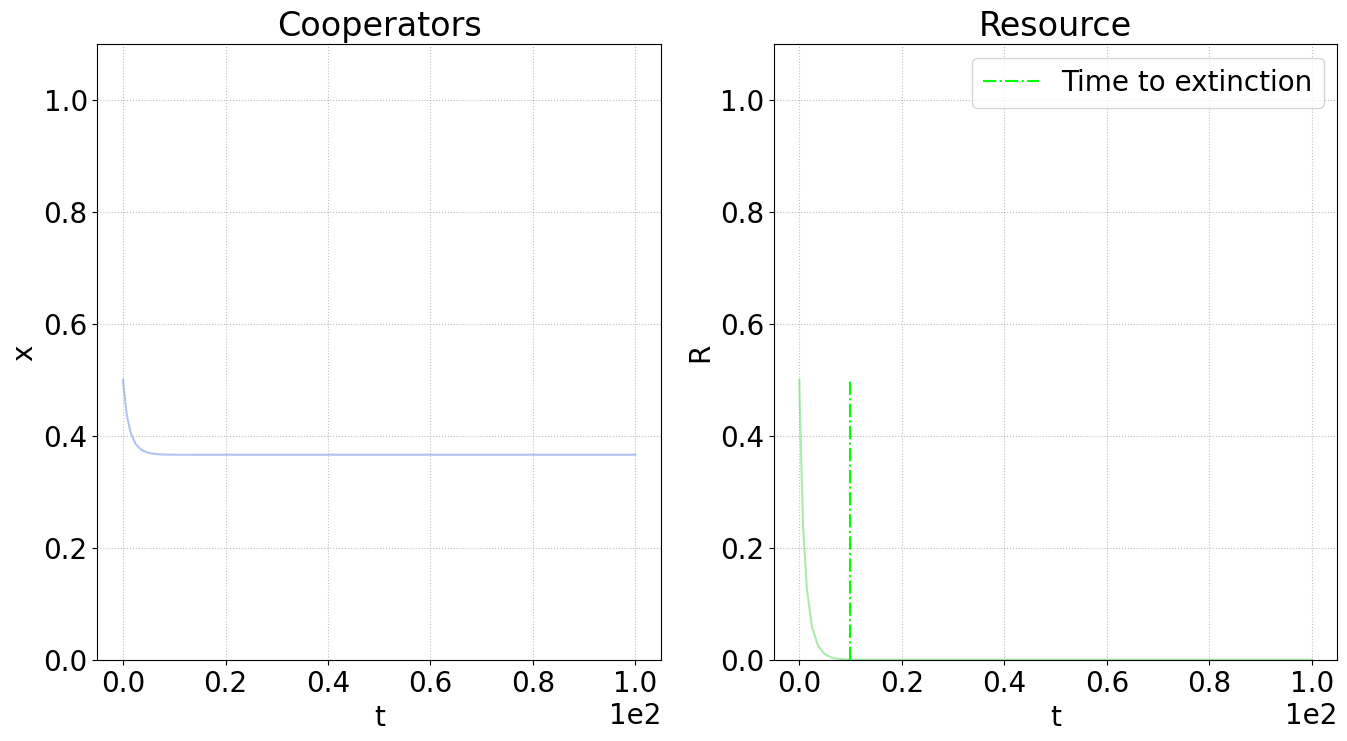

In [3]:
if runMF:
    idxVis_MF = 3

    paramsDictVis_MF =dataObj_MF[idxVis_MF][paramsLabel]
    print('Paremeter set')
    print(json.dumps(paramsDictVis_MF, indent=4))
    seriesObjVis_MF = dataObj_MF[idxVis_MF][seriesLabel]

    # Time to extinction
    print('\nEvaluating the time to extinction')
    tExt_MF = extinctionTime_single(seriesObjVis_MF['time'],seriesObjVis_MF['resource'],tolerance)
    if not tExt_MF:
        print('\tDone. The resource remains sustainable!')
        seriesObjVis_MF['absorbing'] = False
    else:
        seriesObjVis_MF['absorbing'] = True
    print('\tDone.')

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : seriesObjVis_MF['time'],
            'y': seriesObjVis_MF['cooperators'],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : seriesObjVis_MF['time'],
            'y' : seriesObjVis_MF['resource'],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_MF, ax_MF = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_MF,plotsObj):
        ax.set_title(plotObj['name'])
        ax.plot(plotObj['x'],plotObj['y'],plotObj['color'], alpha=0.4)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    if tExt_MF:
        ax_MF[1].vlines(tExt_MF,0,paramsDictVis_MF['Ri'],colors='lime',linestyle='-.',label='Time to extinction')
        ax_MF[1].legend()
    plt.show()

### Phase diagram

Choose a pair of parameters over which to plot the phase diagram. The code selects the relevant data sets.

In [4]:
def stationaryMean(x,y,cut):
        x = np.array(x)
        y = np.array(y)
        idxList = np.where(x > cut)[0]
        if len(idxList)==0:
            raise ValueError('No data satisfying the cut-off detected!')
        return np.mean(y[idxList])

In [5]:
if runMF:
    #######################
    # Collecting the data #
    #######################
    
    paramsGenericDict_MF = copy.copy(paramsDictVis_MF)

    # Pair of parameters over which to build the PD
    PDParamLabels_MF = ['b','ehatD']

    # Object of blocked parameters
    fixedParams_MF = {k:v for k,v in paramsGenericDict_MF.items() if k not in PDParamLabels_MF}

    # Take only the data sets with the chosen parameters fixed
    dataObjPD_MF = []
    for obj in dataObj_MF:
        params_temp = obj[paramsLabel]
        if all(params_temp.get(k) == v for k, v in fixedParams_MF.items()):
            dataObjPD_MF.append(obj)

    paramsPDGrid = []
    xStat_MF = []
    RStat_MF = []
    tExt_MF = []
    for obj in dataObjPD_MF:
        paramsAll = obj[paramsLabel]
        param1PD = paramsAll[PDParamLabels_MF[0]]
        param2PD = paramsAll[PDParamLabels_MF[1]]
        paramsPDGrid.append({k: v for k,v in zip(PDParamLabels_MF,[param1PD,param2PD])})

        t = obj[seriesLabel]['time']
        x = obj[seriesLabel]['cooperators']
        R = obj[seriesLabel]['resource']
        tExt = extinctionTime_single(t,R,tolerance)
        if not tExt:
            tExt_MF.append(np.nan)
        else:
            tExt_MF.append(tExt)

        cut = cutFrac*t[-1]
        xStat_MF.append(stationaryMean(t,x,cut))
        RStat_MF.append(stationaryMean(t,R,cut))

Actual plot

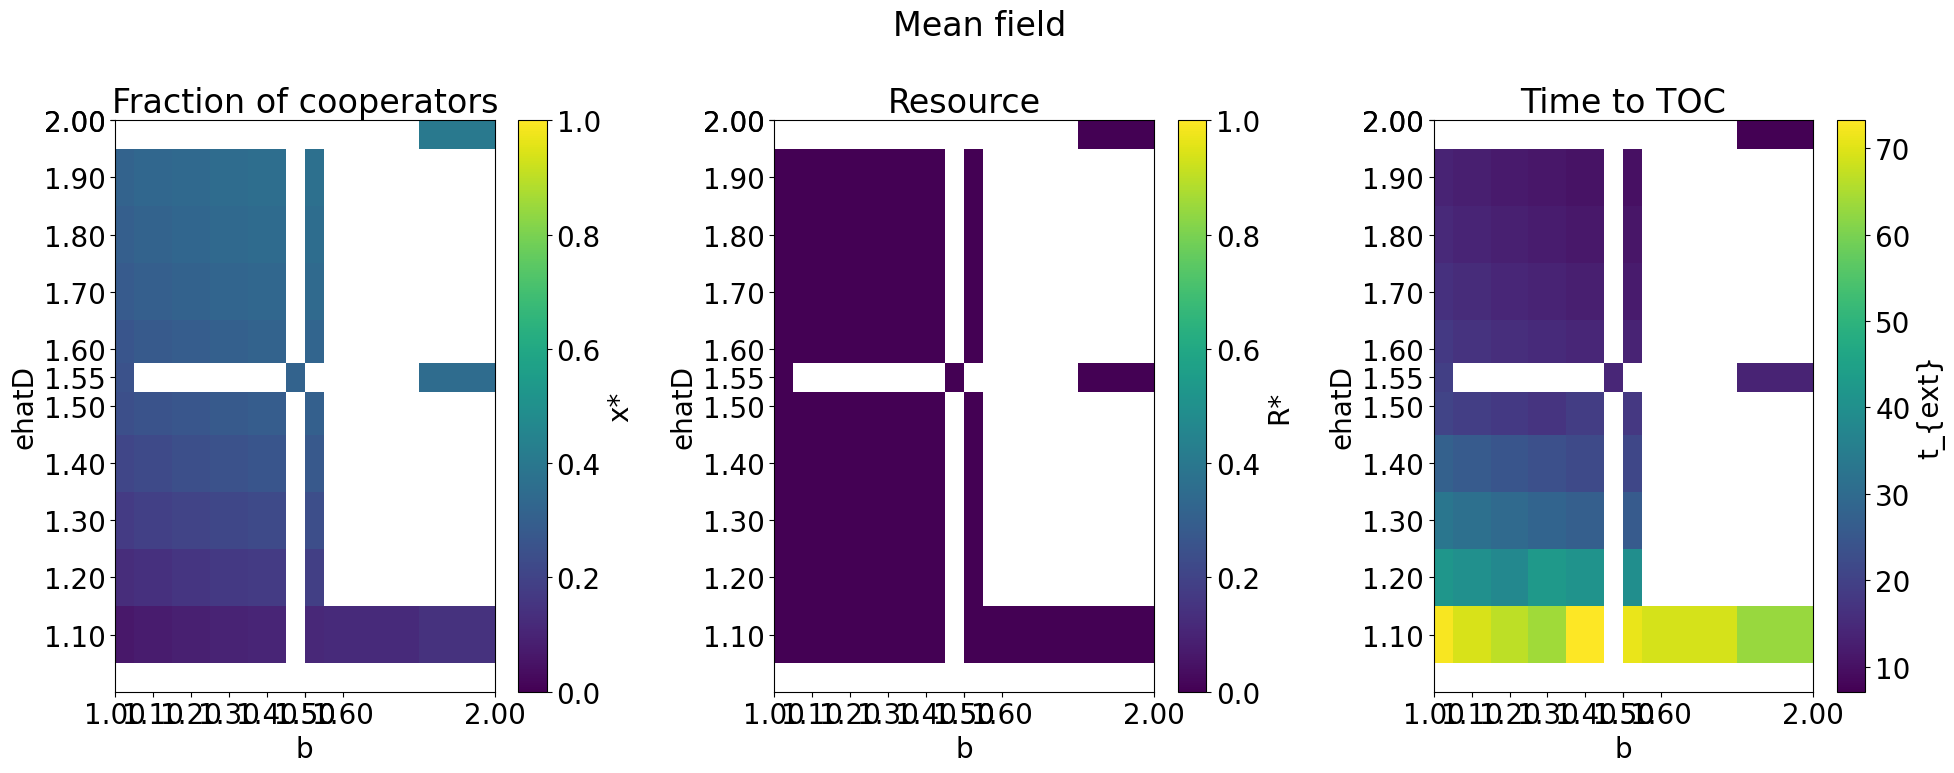

In [6]:
if runMF:
    # Stuff for working with the plot function
    p1PD_allVals = [d[PDParamLabels_MF[0]] for d in paramsPDGrid]
    p2PD_allVals = [d[PDParamLabels_MF[1]] for d in paramsPDGrid]
    p1PD_uniqueVals = np.unique(p1PD_allVals)
    p2PD_uniqueVals = np.unique(p2PD_allVals)
    p1Meshgrid, p2Meshgrid = np.meshgrid(p1PD_uniqueVals,p2PD_uniqueVals)
    xStatPDGrid = np.full(p1Meshgrid.shape,np.nan)
    RStatPDGrid = copy.copy(xStatPDGrid)
    tExtPDGrid = copy.copy(xStatPDGrid)
    for (p1, p2, xS, RS, tE) in zip(p1PD_allVals, p2PD_allVals, xStat_MF, RStat_MF, tExt_MF):
        i = np.where(p1PD_uniqueVals == p1)[0][0]
        j = np.where(p2PD_uniqueVals == p2)[0][0]
        xStatPDGrid[j, i] = xS
        RStatPDGrid[j, i] = RS
        tExtPDGrid[j, i] = tE

    # Actual plot
    figPD_MF, axPD_MF = plt.subplots(1,3,figsize=(20,8))
    figPD_MF.suptitle('Mean field')

    PDxS_MF = axPD_MF[0].pcolormesh(p1Meshgrid,p2Meshgrid,xStatPDGrid,shading='auto',vmin=0,vmax=1)
    figPD_MF.colorbar(PDxS_MF, ax=axPD_MF[0], label='x*')

    PDRS_MF = axPD_MF[1].pcolormesh(p1Meshgrid, p2Meshgrid, RStatPDGrid,vmin=0,vmax=1)
    figPD_MF.colorbar(PDRS_MF, ax=axPD_MF[1], label='R*')

    PDtExt_MF = axPD_MF[2].pcolormesh(p1Meshgrid, p2Meshgrid, tExtPDGrid)
    figPD_MF.colorbar(PDtExt_MF, ax=axPD_MF[2], label='t_{ext}')

    axPD_MF[0].set_title('Fraction of cooperators')
    axPD_MF[1].set_title('Resource')
    axPD_MF[2].set_title('Time to TOC')

    for ax in axPD_MF:
        ax.set_xlabel(PDParamLabels_MF[0])
        ax.set_ylabel(PDParamLabels_MF[1])
        ax.set_xticks(p1PD_uniqueVals)
        ax.set_yticks(p2PD_uniqueVals)
        ax.set_xticklabels([f'{val:.2f}' for val in p1PD_uniqueVals])
        ax.set_yticklabels([f'{val:.2f}' for val in p2PD_uniqueVals])
        ax.set_xlim([1,2])
        ax.set_ylim([1,2])

    plt.tight_layout()
    plt.show()

## Deterministic resource

Import data.

In [7]:
fileList_detRes = [f for f in os.listdir(intputDirsVec[1]) if f.endswith('.json')]
if not fileList_detRes:
    print('No data found.')
    runDetRes = False
else:
    print(f'{len(fileList_detRes)} files found:')
    print(json.dumps(fileList_detRes, indent=4))
    runDetRes = True

    print('Importing.')
    dataObj_detRes = []
    for fName in fileList_detRes:
        with open(os.path.join(intputDirsVec[1], fName), 'r') as f:
            data = json.load(f)
            dataObj_detRes.append(data)
    print('Done.')

66 files found:
[
    "outDetRes_N200.00_K1000.00_b1.10_ehatC0.70_ehatD1.60_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b2.00_ehatC0.70_ehatD2.00_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.00_ehatC0.70_ehatD1.50_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.20_ehatC0.70_ehatD1.30_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.40_ehatC0.70_ehatD1.80_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.00_ehatC0.70_ehatD1.40_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.10_ehatC0.70_ehatD1.70_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.30_ehatC0.70_ehatD1.10_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.20_ehatC0.70_ehatD1.20_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.40_ehatC0.70_ehatD1.90_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.50_ehatC0.70_ehatD1.90_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1.30_ehatC0.70_ehatD1.20_xi0.50_Ri0.50.json",
    "outDetRes_N200.00_K1000.00_b1

## Visualize result of a single simulation

Note: these kind of simulations are obtained by multiple repetitions of a partially-stochastic simulation. Therefore, for each setting of the parameters, many repetitions are collected and the corresponding time series are averaged.

Paremeter set
{
    "N": 200,
    "K": 1000,
    "b": 1.1,
    "ehatC": 0.7,
    "ehatD": 1.6000000000000005,
    "xi": 0.5,
    "Ri": 0.5
}
Evaluating the times to extinction
	Done. 100.0% of the repetitions achieved extinction.


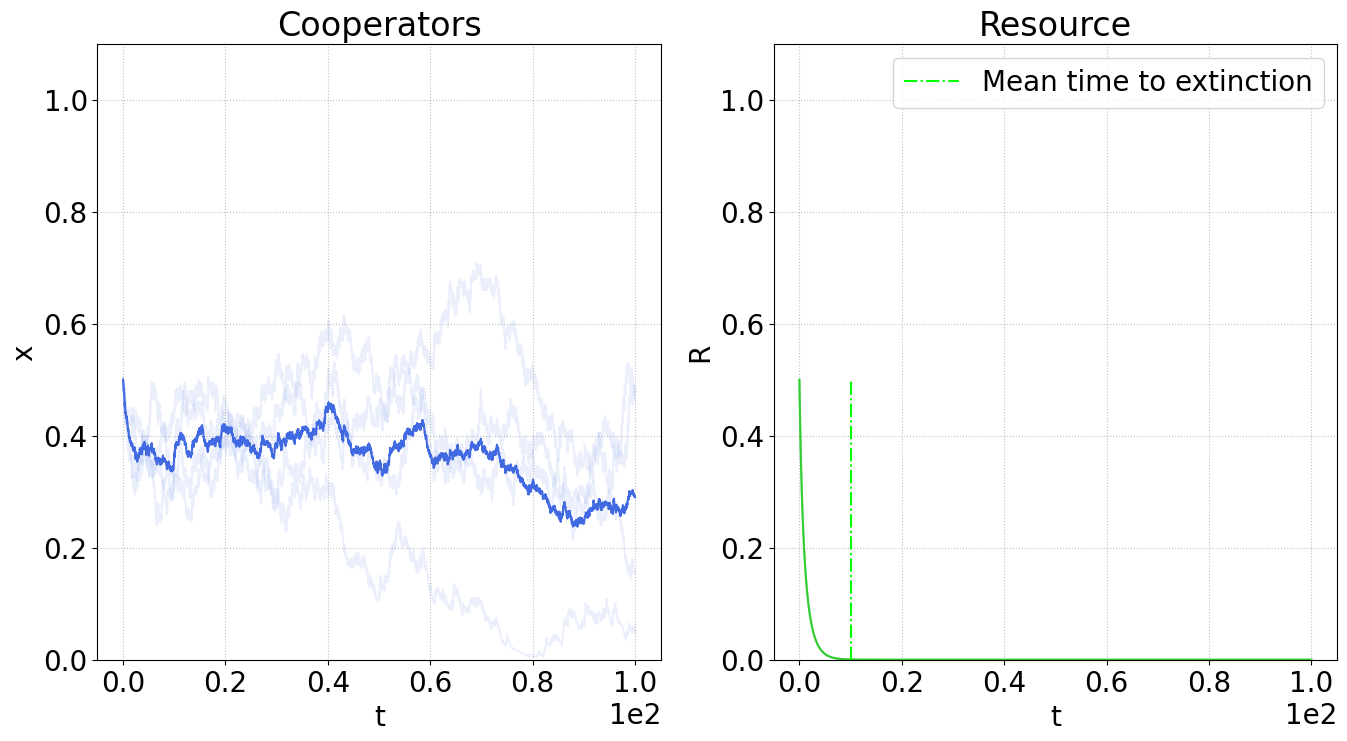

In [8]:
if runDetRes:
    idxVis_detRes = 0

    paramsDictVis_detRes = dataObj_detRes[idxVis_detRes][paramsLabel]
    print('Paremeter set')
    print(json.dumps(paramsDictVis_detRes, indent=4))
    seriesObjVis_detRes = dataObj_detRes[idxVis_detRes][seriesLabel]

    print('Evaluating the times to extinction')
    tExtObj_detRes = extinctionTimes(seriesObjVis_detRes)
    if not tExtObj_detRes['mean']:
        print('\tDone. The resource remains sustainable!')
    else:
        print(f'\tDone. {tExtObj_detRes['fraction']*100}% of the repetitions achieved extinction.')

    # Build a context object for evaluating the interpolating time series
    contextVis_detRes = copy.copy(paramsDictVis_detRes)
    contextVis_detRes['nodeStates'] = nodeStates
    contextVis_detRes['R'] = dataObj_MF[idxVis_detRes][seriesLabel]['resource'][0]
    xiVis_detRes = dataObj_MF[idxVis_detRes][seriesLabel]['cooperators'][0]
    NVis_detRes = paramsDictVis_detRes['N']
    zVis_detRes = np.zeros(NVis_detRes,dtype=int)
    zVis_detRes[0:int(NVis_detRes*paramsDictVis_detRes['xi'])] = setVec(zVis_detRes[0:int(NVis_detRes*paramsDictVis_detRes['xi'])],nodeStates[2])
    zVis_detRes[int(NVis_detRes*paramsDictVis_detRes['xi']):NVis_detRes] = setVec(zVis_detRes[int(NVis_detRes*paramsDictVis_detRes['xi']):NVis_detRes],nodeStates[3])
    contextVis_detRes['varVec'] = zVis_detRes
    contextVis_detRes = paramsDictVis_detRes | contextVis_detRes
    
    # Calculate averages
    if all(len(obj['time']) == 1 for obj in seriesObjVis_detRes):
        matchedMF = None
        for obj in dataObj_MF:
            params_temp = obj[paramsLabel]
            if all(params_temp.get(k) == v for k, v in paramsDictVis_detRes.items()):
                matchedMF = obj 
                break

        if matchedMF is None:
            raise ValueError('No mean field dataset was found for such set of parameters!')

        seriesObjVis_detRes = [matchedMF[seriesLabel].copy() for _ in range(len(seriesObjVis_detRes))]
        tSieriesVisAvg_detRes = matchedMF[seriesLabel]['time'].copy()    
    else:
        tSeriesVisAvg_detRes = tVecCommon(seriesObjVis_detRes,contextVis_detRes,reactsCPRsust_homogeneous_detRes)
    coopFracSeriesInterpVis_detRes = GillTimeSeriesInterp(tSeriesVisAvg_detRes,seriesObjVis_detRes,'cooperators')
    coopFracSeriesAvgVis_detRes = np.mean(coopFracSeriesInterpVis_detRes,axis=0)
    RSeriesInterpVis_detRes = GillTimeSeriesInterp(tSeriesVisAvg_detRes,seriesObjVis_detRes,'resource')
    RSeriesAvgVis_detRes = np.mean(RSeriesInterpVis_detRes,axis=0)
    
    # Redefine the object for plots because the mean field case may not be run
    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : [s['time'] for s in seriesObjVis_detRes],
            'y': [s['cooperators'] for s in seriesObjVis_detRes],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : [s['time'] for s in seriesObjVis_detRes],
            'y' : [s['resource'] for s in seriesObjVis_detRes],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_detRes, ax_detRes = plt.subplots(1,2,figsize=(16,8))
    for ax,plotObj in zip(ax_detRes,plotsObj):
        ax.set_title(plotObj['name'])
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        for kRep in range(len(seriesObjVis_detRes)):
            ax.plot(plotObj['x'][kRep],plotObj['y'][kRep],plotObj['color'], alpha=0.1)
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    ax_detRes[0].plot(tSeriesVisAvg_detRes,coopFracSeriesAvgVis_detRes,color=plotsObj[0]['color'])
    ax_detRes[1].plot(tSeriesVisAvg_detRes,RSeriesAvgVis_detRes,color=plotsObj[1]['color'])
    if tExtObj_detRes['mean']:
        ax_detRes[1].vlines(tExtObj_detRes['mean'],0,paramsDictVis_detRes['Ri'],colors='lime',linestyle='-.',label='Mean time to extinction')
        ax_detRes[1].legend()

### Phase diagram

Choose a pair of parameters over which to plot the phase diagram. The code selects the relevant data sets.

In [9]:
if runDetRes:
    paramsGenericDict_detRes = copy.copy(paramsDictVis_detRes)

    # Pair of parameters over which to build the PD
    PDParamLabels_detRes = ['b','ehatD']

    # Object of blocked parameters
    fixedParams_detRes = {k:v for k,v in paramsGenericDict_detRes.items() if k not in PDParamLabels_detRes}

     # Take only the data sets with the chosen parameters fixed
    dataObjPD_detRes = []
    for obj in dataObj_detRes:
        params_temp = obj[paramsLabel]
        if all(params_temp.get(k) == v for k, v in fixedParams_detRes.items()):
            dataObjPD_detRes.append(obj)

    paramsPDGrid = []
    xStat_detRes = []
    RStat_detRes = []
    tExt_detRes = []
    for obj in dataObjPD_detRes:
        paramsAll = obj[paramsLabel]
        param1PD = paramsAll[PDParamLabels_detRes[0]]
        param2PD = paramsAll[PDParamLabels_detRes[1]]
        paramsPDGrid.append({k: v for k,v in zip(PDParamLabels_detRes,[param1PD,param2PD])})

        seriesObjPD_detRes = obj[seriesLabel]
        
        tList = [o['time'] for o in seriesObjPD_detRes]
        xList = [o['cooperators'] for o in seriesObjPD_detRes]
        RList = [o['resource'] for o in seriesObjPD_detRes]

        # Calculate averages
        if all(len(tS) == 1 for tS in tList):
            matchedMF = None
            for obj in dataObj_MF:
                params_temp = obj[paramsLabel]
                if all(params_temp.get(k) == v for k, v in paramsAll.items()):
                    matchedMF = obj 
                    break

            if matchedMF is None:
                raise ValueError('No mean field dataset was found for such set of parameters!')

            seriesObjPD_detRes = [matchedMF[seriesLabel].copy() for _ in range(len(tList))]
            tSeriesPDAvg_detRes = matchedMF[seriesLabel]['time'].copy()    
        else:
            tSeriesPDAvg_detRes = tVecCommon(seriesObjPD_detRes,contextVis_detRes,reactsCPRsust_homogeneous_detRes)

        coopFracSeriesInterpPD_detRes = GillTimeSeriesInterp(tSeriesPDAvg_detRes,seriesObjPD_detRes,'cooperators')
        coopFracSeriesAvgPD_detRes = np.mean(coopFracSeriesInterpPD_detRes,axis=0)
        RSeriesInterpPD_detRes = GillTimeSeriesInterp(tSeriesPDAvg_detRes,seriesObjPD_detRes,'resource')
        RSeriesAvgPD_detRes = np.mean(RSeriesInterpPD_detRes,axis=0)

        tExt = extinctionTimes(seriesObjPD_detRes)
        if len(tExt['times'])== None:
            tExt['mean'] = np.nan

        cut = cutFrac*tSeriesPDAvg_detRes[-1]
        xStat_detRes.append(stationaryMean(tSeriesPDAvg_detRes,coopFracSeriesAvgPD_detRes,cut))
        RStat_detRes.append(stationaryMean(tSeriesPDAvg_detRes,RSeriesAvgPD_detRes,cut))
        tExt_detRes.append(tExt['mean'])
        

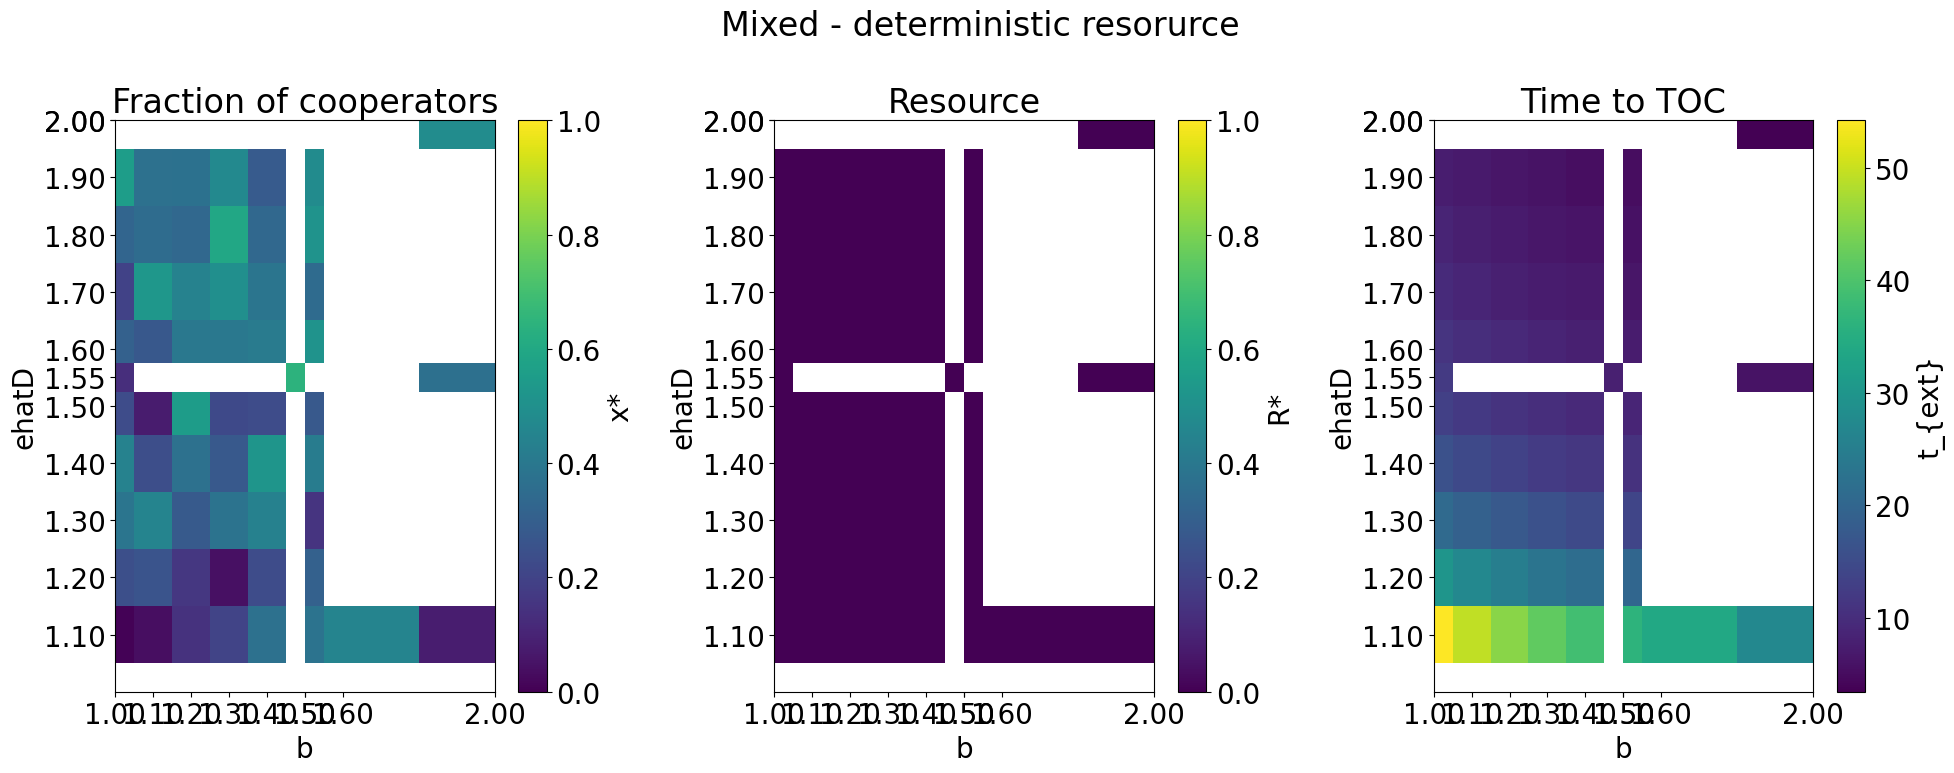

In [10]:
if runDetRes:
    # Stuff for working with the plot function
    p1PD_allVals = [d[PDParamLabels_detRes[0]] for d in paramsPDGrid]
    p2PD_allVals = [d[PDParamLabels_detRes[1]] for d in paramsPDGrid]
    p1PD_uniqueVals = np.unique(p1PD_allVals)
    p2PD_uniqueVals = np.unique(p2PD_allVals)
    p1Meshgrid, p2Meshgrid = np.meshgrid(p1PD_uniqueVals,p2PD_uniqueVals)
    xStatPDGrid = np.full(p1Meshgrid.shape,np.nan)
    RStatPDGrid = copy.copy(xStatPDGrid)
    tExtPDGrid = copy.copy(xStatPDGrid)
    for (p1, p2, xS, RS, tE) in zip(p1PD_allVals, p2PD_allVals, xStat_detRes, RStat_detRes, tExt_detRes):
        i = np.where(p1PD_uniqueVals == p1)[0][0]
        j = np.where(p2PD_uniqueVals == p2)[0][0]
        xStatPDGrid[j, i] = xS
        RStatPDGrid[j, i] = RS
        tExtPDGrid[j, i] = tE

    # Actual plot
    figPD_detRes, axPD_detRes = plt.subplots(1,3,figsize=(20,8))
    figPD_detRes.suptitle('Mixed - deterministic resorurce')

    PDxS_detRes = axPD_detRes[0].pcolormesh(p1Meshgrid,p2Meshgrid,xStatPDGrid,shading='auto',vmin=0,vmax=1)
    figPD_detRes.colorbar(PDxS_detRes, ax=axPD_detRes[0], label='x*')

    PDRS_detRes = axPD_detRes[1].pcolormesh(p1Meshgrid, p2Meshgrid, RStatPDGrid,vmin=0,vmax=1)
    figPD_detRes.colorbar(PDRS_detRes, ax=axPD_detRes[1], label='R*')

    PDtExt_detRes = axPD_detRes[2].pcolormesh(p1Meshgrid, p2Meshgrid, tExtPDGrid)
    figPD_detRes.colorbar(PDtExt_detRes, ax=axPD_detRes[2], label='t_{ext}')

    axPD_detRes[0].set_title('Fraction of cooperators')
    axPD_detRes[1].set_title('Resource')
    axPD_detRes[2].set_title('Time to TOC')

    for ax in axPD_detRes:
        ax.set_xlabel(PDParamLabels_MF[0])
        ax.set_ylabel(PDParamLabels_MF[1])
        ax.set_xticks(p1PD_uniqueVals)
        ax.set_yticks(p2PD_uniqueVals)
        ax.set_xticklabels([f'{val:.2f}' for val in p1PD_uniqueVals])
        ax.set_yticklabels([f'{val:.2f}' for val in p2PD_uniqueVals])
        ax.set_xlim([1,2])
        ax.set_ylim([1,2])

    plt.tight_layout()
    plt.show()

# Stochastic resource

Import data.

In [11]:
fileList_stocRes = [f for f in os.listdir(intputDirsVec[2]) if f.endswith('.json')]
if not fileList_stocRes:
    print('No data found.')
    runStocRes = False
else:
    print(f'{len(fileList_stocRes)} files found:')
    print(json.dumps(fileList_stocRes, indent=4))
    runStocRes = True

    print('Importing.')
    dataObj_stocRes = []
    for fName in fileList_stocRes:
        with open(os.path.join(intputDirsVec[2], fName), 'r') as f:
            data = json.load(f)
            dataObj_stocRes.append(data)
    print('Done.')

65 files found:
[
    "outStocRes_N200.00_K1000.00_b1.40_ehatC0.70_ehatD1.10_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.50_ehatC0.70_ehatD1.20_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.30_ehatC0.70_ehatD1.90_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.50_ehatC0.70_ehatD1.30_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.30_ehatC0.70_ehatD1.80_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.20_ehatC0.70_ehatD1.80_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.40_ehatC0.70_ehatD1.30_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.20_ehatC0.70_ehatD1.90_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.40_ehatC0.70_ehatD1.20_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.50_ehatC0.70_ehatD1.10_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.00_ehatC0.70_ehatD1.55_xi0.50_Ri0.50.json",
    "outStocRes_N200.00_K1000.00_b1.50_ehatC0.70_ehatD1.70_xi0.50_Ri0.50.json",
    "outStocRes_N200.0

## Visualize result of a single simulation

Note: these kind of simulations are obtained by multiple repetitions of a partially-stochastic simulation. Therefore, for each setting of the parameters, many repetitions are collected and the corresponding time series are averaged.

Paremeter set
{
    "N": 200,
    "K": 1000,
    "b": 1.4000000000000004,
    "ehatC": 0.7,
    "ehatD": 1.1,
    "xi": 0.5,
    "Ri": 0.5
}
Evaluating the times to extinction
	Done. The resource remains sustainable!


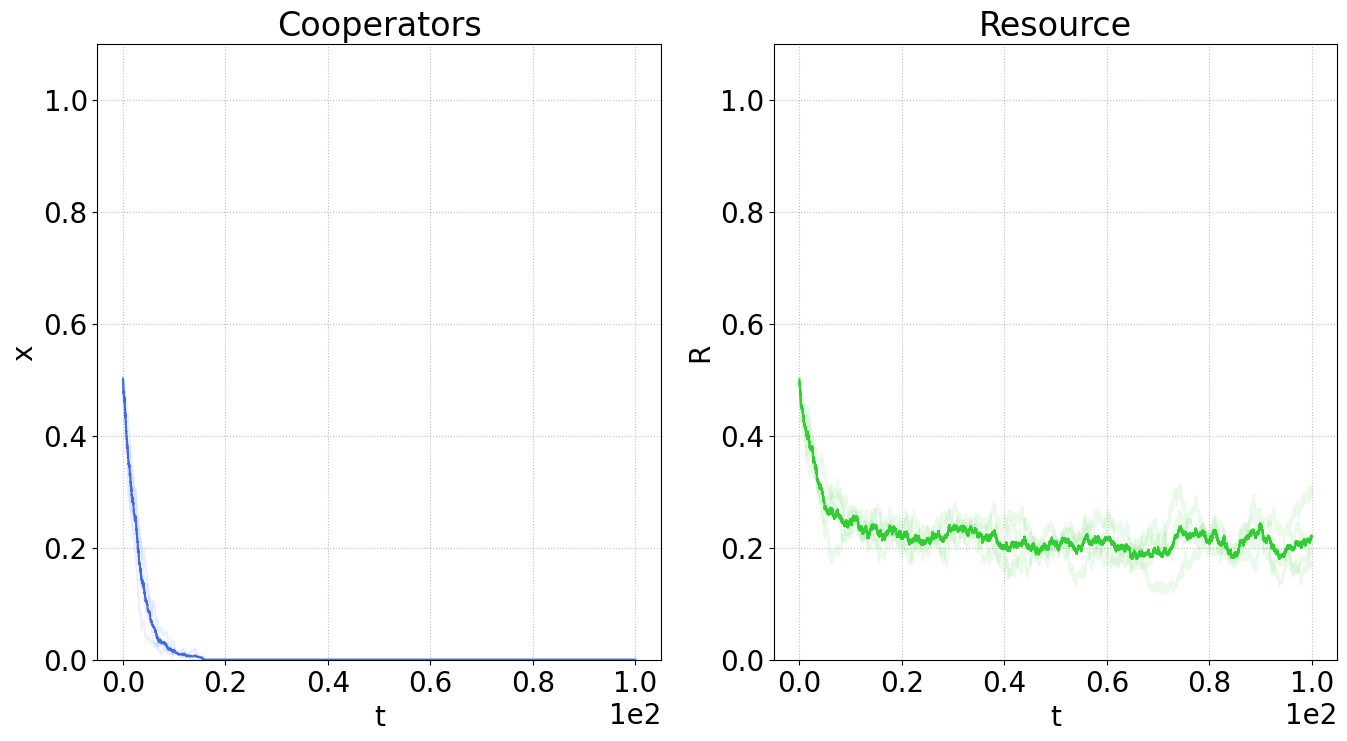

In [12]:
if runStocRes:
    idxVis_stocRes = 0

    paramsDictVis_stocRes = dataObj_stocRes[idxVis_stocRes][paramsLabel]
    print('Paremeter set')
    print(json.dumps(paramsDictVis_stocRes, indent=4))
    seriesObjVis_stocRes = dataObj_stocRes[idxVis_stocRes][seriesLabel]

    print('Evaluating the times to extinction')
    tExtObj_stocRes = extinctionTimes(seriesObjVis_stocRes)
    if not tExtObj_stocRes['mean']:
        print('\tDone. The resource remains sustainable!')
    else:
        print(f'\tDone. {tExtObj_stocRes['fraction']*100}% of the repetitions achieved extinction.')

    # Build a context object for evaluating the interpolating time series
    contextVis_stocRes = copy.copy(paramsDictVis_stocRes)
    contextVis_stocRes['nodeStates'] = nodeStates
    contextVis_stocRes['extractionRates'] = [paramsDictVis_stocRes['ehatC'],paramsDictVis_stocRes['ehatD']]
    RiVis_stocRes = seriesObjVis_stocRes[idxVis_stocRes]['resource'][0]
    xiVis_stocRes = seriesObjVis_stocRes[idxVis_stocRes]['cooperators'][0]
    KVis_stocRes = paramsDictVis_stocRes['K']
    NVis_stocRes = paramsDictVis_stocRes['N']
    zVis_stocRes = np.zeros(NVis_stocRes+KVis_stocRes,dtype=int)
    zVis_stocRes[0:int(NVis_stocRes*paramsDictVis_stocRes['xi'])] = setVec(zVis_detRes[0:int(NVis_stocRes*paramsDictVis_stocRes['xi'])],nodeStates[2])
    zVis_stocRes[int(NVis_stocRes*paramsDictVis_stocRes['xi']):NVis_stocRes] = setVec(zVis_stocRes[int(NVis_stocRes*paramsDictVis_stocRes['xi']):NVis_stocRes],nodeStates[3])
    zVis_stocRes[NVis_stocRes:NVis_stocRes+int(KVis_stocRes*paramsDictVis_stocRes['Ri'])] = setVec(zVis_stocRes[NVis_stocRes:NVis_stocRes+int(KVis_stocRes*paramsDictVis_stocRes['Ri'])],nodeStates[1])
    zVis_stocRes[NVis_stocRes+int(KVis_stocRes*paramsDictVis_stocRes['Ri']):] = setVec(zVis_stocRes[NVis_stocRes+int(KVis_stocRes*paramsDictVis_stocRes['Ri']):],nodeStates[0])
    contextVis_stocRes['varVec'] = zVis_stocRes
    contextVis_stocRes = paramsDictVis_detRes | contextVis_stocRes
    
    # Calculate averages
    tSeriesVisAvg_stocRes = tVecCommon(seriesObjVis_stocRes,contextVis_stocRes,reactsCPRsust_homogeneous_stocRes)
    coopFracSeriesInterpVis_stocRes = GillTimeSeriesInterp(tSeriesVisAvg_stocRes,seriesObjVis_stocRes,'cooperators')
    coopFracSeriesAvgVis_stocRes = np.mean(coopFracSeriesInterpVis_stocRes,axis=0)
    RSeriesInterpVis_stocRes = GillTimeSeriesInterp(tSeriesVisAvg_stocRes,seriesObjVis_stocRes,'resource')
    RSeriesAvgVis_stocRes = np.mean(RSeriesInterpVis_stocRes,axis=0)
    
    # Redefine the object for plots because the previous cases may not be run
    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : [s['time'] for s in seriesObjVis_stocRes],
            'y': [s['cooperators'] for s in seriesObjVis_stocRes],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : [s['time'] for s in seriesObjVis_stocRes],
            'y' : [s['resource'] for s in seriesObjVis_stocRes],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_detRes, ax_detRes = plt.subplots(1,2,figsize=(16,8))
    for ax,plotObj in zip(ax_detRes,plotsObj):
        ax.set_title(plotObj['name'])
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        for kRep in range(len(seriesObjVis_detRes)):
            ax.plot(plotObj['x'][kRep],plotObj['y'][kRep],plotObj['color'], alpha=0.1)
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    ax_detRes[0].plot(tSeriesVisAvg_stocRes,coopFracSeriesAvgVis_stocRes,color=plotsObj[0]['color'])
    ax_detRes[1].plot(tSeriesVisAvg_stocRes,RSeriesAvgVis_stocRes,color=plotsObj[1]['color'])
    if tExtObj_stocRes['mean']:
        ax_detRes[1].vlines(tExtObj_stocRes['mean'],0,paramsDictVis_stocRes['Ri'],colors='lime',linestyle='-.',label='Mean time to extinction')
        ax_detRes[1].legend()

### Phase diagram

Choose a pair of parameters over which to plot the phase diagram. The code selects the relevant data sets.

In [13]:
if runStocRes:
    paramsGenericDict_stocRes = copy.copy(paramsDictVis_stocRes)

    # Pair of parameters over which to build the PD
    PDParamLabels_stocRes = ['b','ehatD']

    # Object of blocked parameters
    fixedParams_stocRes = {k:v for k,v in paramsGenericDict_stocRes.items() if k not in PDParamLabels_stocRes}

     # Take only the data sets with the chosen parameters fixed
    dataObjPD_stocRes = []
    for obj in dataObj_stocRes:
        params_temp = obj[paramsLabel]
        if all(params_temp.get(k) == v for k, v in fixedParams_stocRes.items()):
            dataObjPD_stocRes.append(obj)

    paramsPDGrid = []
    xStat_stocRes = []
    RStat_stocRes = []
    tExt_stocRes = []
    for obj in dataObjPD_stocRes:
        paramsAll = obj[paramsLabel]
        param1PD = paramsAll[PDParamLabels_detRes[0]]
        param2PD = paramsAll[PDParamLabels_detRes[1]]
        paramsPDGrid.append({k: v for k,v in zip(PDParamLabels_detRes,[param1PD,param2PD])})

        seriesObjPD_stocRes = obj[seriesLabel]
        
        tList = [o['time'] for o in seriesObjPD_stocRes]
        xList = [o['cooperators'] for o in seriesObjPD_stocRes]
        RList = [o['resource'] for o in seriesObjPD_stocRes]

        tSeriesPDAvg_stocRes = tVecCommon(seriesObjPD_stocRes,contextVis_stocRes,reactsCPRsust_homogeneous_stocRes)
        coopFracSeriesInterpPD_stocRes = GillTimeSeriesInterp(tSeriesPDAvg_stocRes,seriesObjPD_stocRes,'cooperators')
        coopFracSeriesAvgPD_stocRes = np.mean(coopFracSeriesInterpPD_stocRes,axis=0)
        RSeriesInterpPD_stocRes = GillTimeSeriesInterp(tSeriesPDAvg_stocRes,seriesObjPD_stocRes,'resource')
        RSeriesAvgPD_stocRes = np.mean(RSeriesInterpPD_stocRes,axis=0)

        tExt = extinctionTimes(seriesObjPD_stocRes)
        if len(tExt['times'])== None:
            tExt['mean'] = np.nan

        cut = cutFrac*tSeriesPDAvg_stocRes[-1]
        xStat_stocRes.append(stationaryMean(tSeriesPDAvg_stocRes,coopFracSeriesAvgPD_stocRes,cut))
        RStat_stocRes.append(stationaryMean(tSeriesPDAvg_stocRes,RSeriesAvgPD_stocRes,cut))
        tExt_stocRes.append(tExt['mean'])

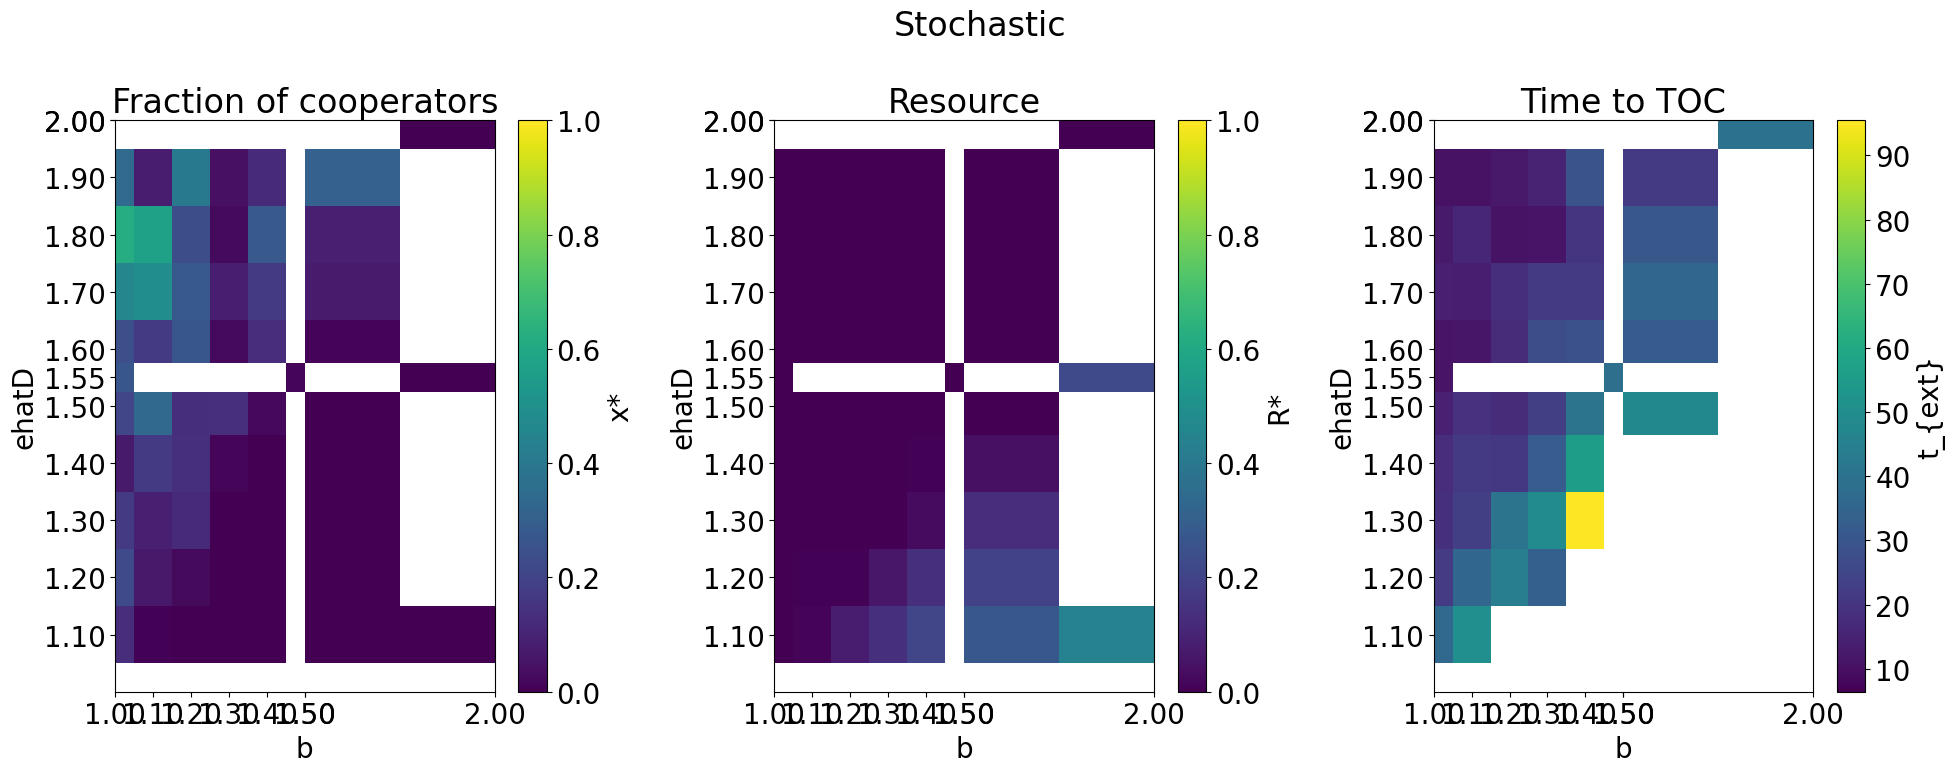

In [14]:
if runStocRes:
    # Stuff for working with the plot function
    p1PD_allVals = [d[PDParamLabels_stocRes[0]] for d in paramsPDGrid]
    p2PD_allVals = [d[PDParamLabels_stocRes[1]] for d in paramsPDGrid]
    p1PD_uniqueVals = np.unique(p1PD_allVals)
    p2PD_uniqueVals = np.unique(p2PD_allVals)
    p1Meshgrid, p2Meshgrid = np.meshgrid(p1PD_uniqueVals,p2PD_uniqueVals)
    xStatPDGrid = np.full(p1Meshgrid.shape,np.nan)
    RStatPDGrid = copy.copy(xStatPDGrid)
    tExtPDGrid = copy.copy(xStatPDGrid)
    for (p1, p2, xS, RS, tE) in zip(p1PD_allVals, p2PD_allVals, xStat_stocRes, RStat_stocRes, tExt_stocRes):
        i = np.where(p1PD_uniqueVals == p1)[0][0]
        j = np.where(p2PD_uniqueVals == p2)[0][0]
        xStatPDGrid[j, i] = xS
        RStatPDGrid[j, i] = RS
        tExtPDGrid[j, i] = tE

    # Actual plot
    figPD_stocRes, axPD_stocRes = plt.subplots(1,3,figsize=(20,8))
    figPD_stocRes.suptitle('Stochastic')

    PDxS_stocRes = axPD_stocRes[0].pcolormesh(p1Meshgrid,p2Meshgrid,xStatPDGrid,shading='auto',vmin=0,vmax=1)
    figPD_stocRes.colorbar(PDxS_stocRes, ax=axPD_stocRes[0], label='x*')

    PDRS_stocRes = axPD_stocRes[1].pcolormesh(p1Meshgrid, p2Meshgrid, RStatPDGrid,vmin=0,vmax=1)
    figPD_stocRes.colorbar(PDRS_stocRes, ax=axPD_stocRes[1], label='R*')

    PDtExt_stocRes = axPD_stocRes[2].pcolormesh(p1Meshgrid, p2Meshgrid, tExtPDGrid)
    figPD_stocRes.colorbar(PDtExt_stocRes, ax=axPD_stocRes[2], label='t_{ext}')

    axPD_stocRes[0].set_title('Fraction of cooperators')
    axPD_stocRes[1].set_title('Resource')
    axPD_stocRes[2].set_title('Time to TOC')

    for ax in axPD_stocRes:
        ax.set_xlabel(PDParamLabels_MF[0])
        ax.set_ylabel(PDParamLabels_MF[1])
        ax.set_xticks(p1PD_uniqueVals)
        ax.set_yticks(p2PD_uniqueVals)
        ax.set_xticklabels([f'{val:.2f}' for val in p1PD_uniqueVals])
        ax.set_yticklabels([f'{val:.2f}' for val in p2PD_uniqueVals])
        ax.set_xlim([1,2])
        ax.set_ylim([1,2])

    plt.tight_layout()
    plt.show()